In [1]:
import sys
sys.path.append("..")
print(sys.path)

['/home/ws/upecj/SafeTransferLearningInChangingEnvironments/src/notebooks', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/ws/upecj/SafeTransferLearningInChangingEnvironments/venv/lib/python3.8/site-packages', '/home/ws/upecj/SafeTransferLearningInChangingEnvironments/src/custom_envs', '/home/ws/upecj/SafeTransferLearningInChangingEnvironments/venv/lib/python3.8/site-packages/IPython/extensions', '/home/ws/upecj/.ipython', '..']


In [2]:
from wrappers.preference_reward.model_wrapper import ModelWrapper
from wrappers.preference_reward.preference_reward import PreferenceReward
import gym
import custom_robotics
import wrappers
from custom_policies import custom_feature_extractor

from stable_baselines3 import SAC, HerReplayBuffer
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback
import wandb
from wandb.integration.sb3 import WandbCallback
import numpy as np

In [3]:
config = {
    "gamma": 0.95,
    "learning_rate": 0.0001,
    "alpha": 0.3,
    "total_timesteps": int(2e6),
    "ep_length": 100,
    "mean": 0.3,
    "sigma": 0.2,
    "cost_factor": 10
}
name = "SAC_state_ensemble_cost_10"
base_folder = "../../output"
project_name = "fetch-push-cost"

In [4]:
run = wandb.init(
    project=project_name,
    entity="f-krone",
    name=name,
    config=config,
    #sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
    monitor_gym=True,  # auto-upload the videos of agents playing the game
    save_code=True,  # optional
)
wandb.tensorboard.patch(root_logdir=f'{base_folder}/{project_name}/{name}_{run.id}/runs', pytorch=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: f-krone (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.14 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [5]:
def load_model(file_name):
    def make_ensemble_env():
            env = gym.make("FetchPushDense-v1")
            env = Monitor(env)  # record stats such as returns
            return env
    ensemble_env = DummyVecEnv([make_ensemble_env])
    return SAC.load(file_name, ensemble_env)

In [6]:
model_wrapper = ModelWrapper(list(map(lambda i: load_model("../../output/fetch-push-ensemble/SAC_ensemble_" + str(i)), range(3))), obs_keys=["achieved_goal", "desired_goal", "observation"], remove_barrier=True)

In [7]:
def make_env():
    env = gym.make("CustomFetchPushCostDense-v0")
    env = wrappers.RemoveRobot(env)
    env = wrappers.CostWrapper(env, cost_factor=config["cost_factor"], tensorboard_log=f'{base_folder}/{project_name}/{name}_{run.id}/runs')
    env = Monitor(env)  # record stats such as returns
    env = PreferenceReward(env, model_wrapper, 4, lambda steps: 1 - steps / config["total_timesteps"], tensorboard_log=f'{base_folder}/{project_name}/{name}_{run.id}/runs')
    return env
def make_eval_env():
    env = gym.make("CustomFetchPushCostDense-v0")
    env = wrappers.RemoveRobot(env)
    env = wrappers.CostWrapper(env, cost_factor=config["cost_factor"], tensorboard_log=f'{base_folder}/{project_name}/{name}_{run.id}/runs')
    env = Monitor(env)  # record stats such as returns
    return env
    
env = DummyVecEnv([make_env])
eval_env = DummyVecEnv([make_eval_env])
eval_env = VecVideoRecorder(eval_env, f"{base_folder}/{project_name}/{name}_{run.id}/videos", record_video_trigger=lambda x: x== 0, video_length=300)

In [8]:
model = SAC('MultiInputPolicy', env, 
            learning_starts=int(1e4), 
            buffer_size=int(2e6),
            gamma=config["gamma"],
            learning_rate=config["learning_rate"],
            policy_kwargs=dict(
                net_arch=[512, 256, 256]
            ),
            action_noise=OrnsteinUhlenbeckActionNoise(np.zeros(shape=4) + config["mean"], np.zeros(shape=4) + config["sigma"]),
            replay_buffer_class=HerReplayBuffer,
            replay_buffer_kwargs=dict(
                online_sampling=True,
                goal_selection_strategy='future',
                n_sampled_goal=4
            ),
            verbose=1, tensorboard_log=f'{base_folder}/{project_name}/{name}_{run.id}/runs')

Using cuda device


In [ ]:
model.learn(
        total_timesteps=config["total_timesteps"],
        callback=[
            WandbCallback(
                gradient_save_freq=100,
                model_save_path=f"{base_folder}/{project_name}/{name}_{run.id}/models",
                verbose=2), 
            CheckpointCallback(
                save_freq=25000, 
                save_path=f"{base_folder}/{project_name}/{name}_{run.id}/checkpoints",
                name_prefix='rl_model'),
            EvalCallback(
                eval_env, 
                best_model_save_path=f"{base_folder}/{project_name}/{name}_{run.id}/best_model",
                log_path=f"{base_folder}/{project_name}/{name}_{run.id}/best_model", 
                eval_freq=5000,
                deterministic=True,
                render=False)
        ],
    )
model.save(f"{base_folder}/{project_name}/{name}_{run.id}")

Logging to ../../output/fetch-push-cost/SAC_state_ensemble_cost_10_3cf0xl5o/runs/SAC_1


/home/ws/upecj/SafeTransferLearningInChangingEnvironments/venv/lib/python3.8/site-packages/stable_baselines3/common/callbacks.py:337: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f2f485edee0> != <stable_baselines3.common.vec_env.vec_video_recorder.VecVideoRecorder object at 0x7f2f482f0fd0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")
File ../../output/fetch-push-cost/SAC_state_ensemble_cost_10_3cf0xl5o/runs/events.out.tfevents.1649762201.oko.3801726.0 updated even though the current file is ../../output/fetch-push-cost/SAC_state_ensemble_cost_10_3cf0xl5o/runs/events.out.tfevents.1649762201.oko.3801726.2


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -99.6    |
|    success_rate    | 0.0      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 254      |
|    time_elapsed    | 1        |
|    total_timesteps | 400      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -104     |
|    success_rate    | 0.0      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 268      |
|    time_elapsed    | 2        |
|    total_timesteps | 800      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -94.5    |
|    success_rate    | 0.0      |
| time/              |          |
|    episodes        | 12       |
|    fps      

In [10]:
run.finish()

SAC_1/eval/mean_ep_length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
SAC_1/eval/mean_reward,▇▄▁▇▇▆▇▆▇▇▇▇▆▁▇█▇▇▁█▇▇▇▇▆▆▇▇▇▇▆▇▇▆▇▅▇▇▇▇
SAC_1/eval/success_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
SAC_1/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
SAC_1/rollout/ep_len_mean,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
SAC_1/rollout/ep_rew_mean,▂▅▃▁▄▆▆▇▆▇▇▇█▇▇██▇▇▇▇▇▇▇▇▇█▇▇███▇▇█▇██▇█
SAC_1/rollout/success_rate,▁▁▃▆▁▆▁▃▁▃▃▁▁▁▁▁▁▃▃▁▃▁▃▆▁▁█▁▆▁▁▆▆▃▃▃▁▁▁▁
SAC_1/time/fps,█▅▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
SAC_1/train/actor_loss,▁█▇█████████████████████████████████████
SAC_1/train/critic_loss,▁▁▁▁▁▂▁▁▁▃▂▁▁▂▃▁▁▃▁▄▁▃▁▂▃▂▁▂▁▁▄▂▄▁▄█▂▁▆▂
SAC_1/train/ent_coef,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [12]:
model.save(f"{base_folder}/{name}_{run.id}")

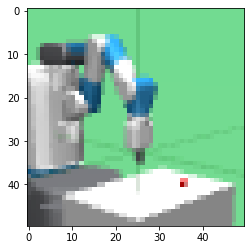

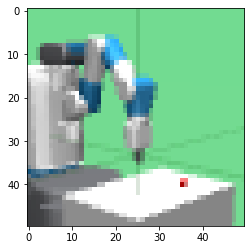

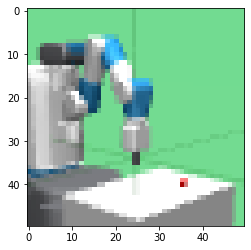

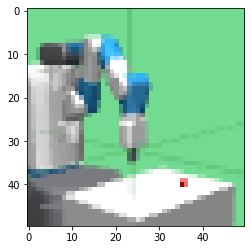

In [16]:
import matplotlib.pyplot as plt
for i, frame in enumerate(np.moveaxis(env._obs_from_buf()['frame_stack_3d'][0], 0, 1)):
    plt.figure(i)
    plt.clf()
    plt.imshow(np.moveaxis(frame, 0, -1))

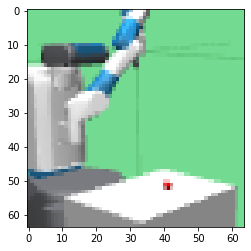

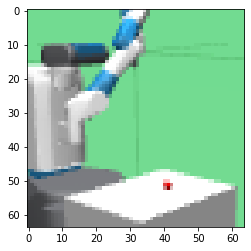

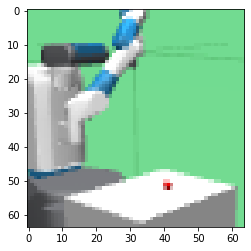

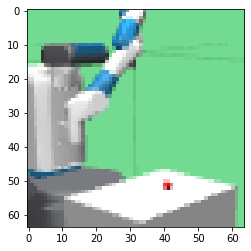

In [26]:
import matplotlib.pyplot as plt
for i, frame in enumerate(env._obs_from_buf()['frame_stack_2d'][0]):
    plt.figure(i)
    plt.clf()
    plt.imshow(frame)